In [1]:
%matplotlib notebook
import numpy as np
import torch
import torchvision.transforms as Transforms
from skimage import io, transform
import glob
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import os
import pickle
from skimage import exposure

In [34]:
image_files = glob.glob(".\\og_images\\*")
label_dir = ".\\og_landmarks"
global_counter = 0
data ={"images":[], "landmarks":[]}
contourtypes = ["contourL.txt", "contourM.txt"]
for image_file_path in image_files:
    meta = image_file_path.split("\\")[2].split("_")
    id = meta[0]
    side = meta[2].split(".")[0]
    labels = []
    print(id, side)
    for contourtype in contourtypes:
        label_file_name = label_dir+"\\"+str(id)+"_AP_femur_"+side+"_"+contourtype
        labels.append(np.loadtxt(label_file_name))
    labels = np.vstack(labels)
    newimagepath = ".\\aug_images\\"+str(global_counter)+".jpg"
    newlabelspath = ".\\aug_landmarks\\"+str(global_counter)+".txt"
    shutil.copy(image_file_path, newimagepath)
    np.savetxt(newlabelspath, labels)
    global_counter += 1
    data["images"].append(newimagepath)
    data["landmarks"].append(newlabelspath)
pickle.dump(data, open("datalist.p", "wb"))

0 left
0 right
100 left
100 right
101 left
101 right
102 left
102 right
103 left
103 right
104 left
104 right
105 left
105 right
106 left
106 right
107 left
107 right
108 left
108 right
109 left
109 right
10 left
10 right
110 left
110 right
112 left
112 right
113 left
113 right
114 left
114 right
11 left
11 right
123 left
123 right
124 left
124 right
12 left
12 right
13 left
13 right
14 right
19 left
19 right
1 left
1 right
21 left
21 right
22 left
22 right
24 left
24 right
25 left
25 right
28 left
28 right
30 left
30 right
32 left
32 right
33 left
33 right
34 left
34 right
353 left
356 left
358 left
359 left
35 left
35 right
360 left
361 right
363 right
364 left
365 left
366 right
367 left
368 right
36 left
36 right
370 right
371 right
375 right
377 right
379 left
379 right
37 left
37 right
380 left
380 right
381 left
381 right
382 left
382 right
383 left
383 right
39 left
39 right
3 left
3 right
40 right
41 left
41 right
42 left
42 right
43 right
44 left
44 right
45 left
45 right
46 

In [73]:
image_files[39]

'.\\og_images\\12_AP_right.jpg'

In [35]:
data = pickle.load(open( "datalist.p", "rb" ))

In [74]:
data["images"][39]

'.\\aug_images\\39.jpg'

In [37]:
def test_image_plot(image_, labels):
    plt.imshow(image_, cmap="gray")
    print(labels.shape)
    plt.scatter(labels[:,0], labels[:,1], s=1)
    plt.show()

<IPython.core.display.Javascript object>


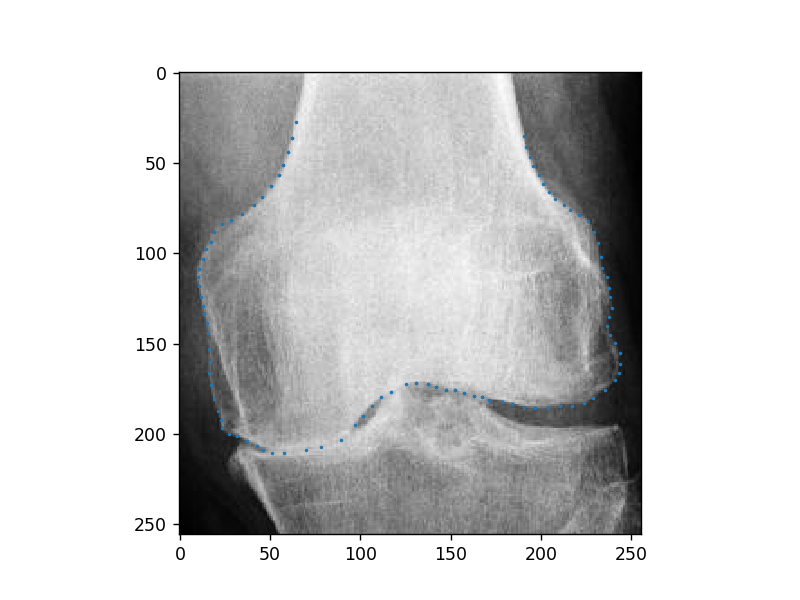

(130, 2)


In [103]:
test_image_plot(io.imread(data["images"][39]), np.loadtxt(data["landmarks"][39]))

In [5]:
import math
def generate_heatmap(coords, image_size, heatmap):
    # landmark holds the image
    #heatmap = np.zeros(image_size, dtype=np.float32)
    sigma = 1.5
    sigma_scale_factor = 1.0
    size_sigma_factor = 10
    scale_factor = 1.0
    normalize_center = True
    dim = 2


    # flip point from [x, y, z] to [z, y, x]
    flipped_coords = np.flip(coords, 0)
    region_start = (flipped_coords - sigma * size_sigma_factor / 2).astype(int)
    region_end = (flipped_coords + sigma * size_sigma_factor / 2).astype(int)

    region_start = np.maximum(0, region_start).astype(int)
    region_end = np.minimum(image_size, region_end).astype(int)

    # return zero landmark, if region is invalid, i.e., landmark is outside of image
    if np.any(region_start >= region_end):
        return heatmap

    region_size = (region_end - region_start).astype(int)

    sigma = sigma * sigma_scale_factor
    scale = scale_factor

    if not normalize_center:
        scale /= math.pow(math.sqrt(2 * math.pi) * sigma, dim)

    if dim == 2:
        dy, dx = np.meshgrid(range(region_size[1]), range(region_size[0]))
        x_diff = dx + region_start[0] - flipped_coords[0]
        y_diff = dy + region_start[1] - flipped_coords[1]

        squared_distances = x_diff * x_diff + y_diff * y_diff

        cropped_heatmap = scale * np.exp(-squared_distances / (2 * math.pow(sigma, 2)))

        heatmap[region_start[0]:region_end[0],
                region_start[1]:region_end[1]] = cropped_heatmap[:, :]
    return heatmap
def generate_all_heatmaps(landmarks, image_size):
    heatmaps = np.zeros((landmarks.shape[0], image_size[0], image_size[1]), dtype=np.float32)
    for i in range(landmarks.shape[0]):
        heatmaps[i,:,:] = generate_heatmap(landmarks[i], image_size, heatmaps[i,:,:])
    return heatmaps

In [6]:
landmarks = np.loadtxt(data["label_filename"][-1])
image = Image.imread(data["image_filenames"][-1])
image_size = (h, w) = image.shape[0], image.shape[1]

NameError: name 'Image' is not defined

In [17]:
image_size

(2010, 2446)

In [98]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        #print(image.shape)
        h, w = image.shape[:2]
        min_x = np.min(landmarks[:,0])
        max_y = np.max(landmarks[:,1])
        
        crop_max_y = int(max_y+100) if int(max_y+100) <= h else max_y 
        crop_min_x = int(min_x - 100) if int(min_x - 100)>=0 else min_x
        #print(crop_max_y, crop_min_x)
        image = image[:crop_max_y+1, crop_min_x:]
        landmarks[:,0] = landmarks[:,0] - crop_min_x
        
        mid_x = crop_min_x + (w-1)/2
        mid_y = crop_max_y/2
        bounding_box = {'bx':mid_x, 'by':mid_y, 'bh':image.shape[0], 'bw':image.shape[1]}
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        
        image = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        
        h, w  = image.shape[:2]
        min_x = np.min(landmarks[:,0])
        #landmarks[:,0] = landmarks[:,0] - (image.shape[0] - int(self.output_size))
        # special case for 12_AP_right.jpg otherwise select the bottomost size x size subimage box 
        image = image[h-int(self.output_size):, int(min_x-10):int(min_x-10+self.output_size)]
        landmarks = landmarks - [min_x-10, h-int(self.output_size)]
        '''
        image_height, image_width = image.shape
        crop_height, crop_width = self.output_size, self.output_size
        crop_top = int(round((image_height - crop_height) / 2.))
        crop_left = int(round((image_width - crop_width) / 2.))
        image = image[crop_top:crop_top+self.output_size, crop_left:crop_left+self.output_size]
        landmarks = landmarks - [crop_left, crop_top]
        '''
        return {'image': image, 'landmarks': landmarks, 'bounding_box':bounding_box}

(256, 256) {'bx': 2847.5, 'by': 438.0, 'bh': 877, 'bw': 821}


<IPython.core.display.Javascript object>


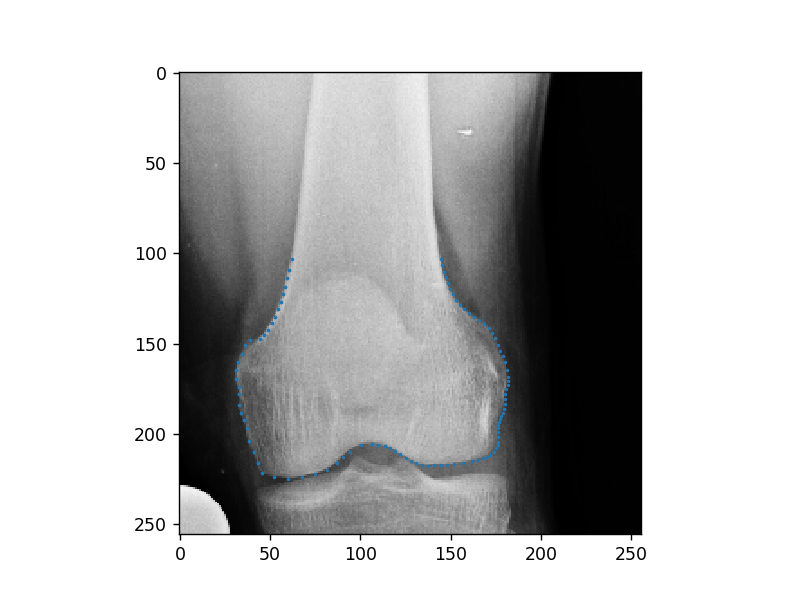

(130, 2)


In [69]:
scale = Rescale(256)
sample = {"image":io.imread(data["images"][-1], as_gray=True), "landmarks":np.loadtxt(data["landmarks"][-1])}
sample = scale(sample)
#sample["landmarks"].shape
print(sample["image"].shape, sample["bounding_box"])
test_image_plot(sample["image"], sample["landmarks"])

In [70]:
data["bounding_box"] = []
for image_filename, landmark_filename in zip(data["images"], data["landmarks"]):
    sample = {"image":io.imread(image_filename, as_gray=True), "landmarks":np.loadtxt(landmark_filename)}
    sample = scale(sample)
    np.savetxt(landmark_filename, sample["landmarks"])
    io.imsave(image_filename, sample["image"])
    data["bounding_box"].append(sample["bounding_box"])

In [75]:
pickle.dump(data, open("datalist.p", "wb"))

<IPython.core.display.Javascript object>


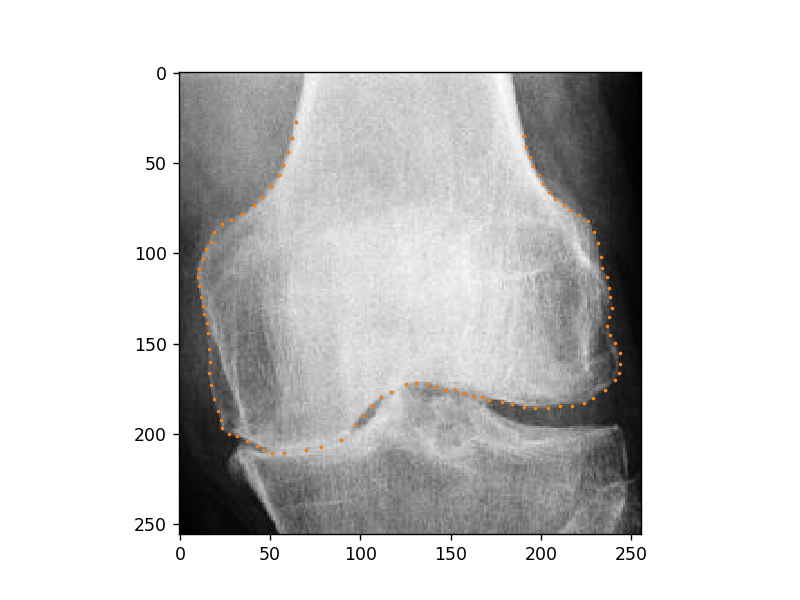

(130, 2)
(256, 256)


In [101]:
labels = []
for contourtype in contourtypes:
    labels.append(np.loadtxt(".//og_landmarks//12_AP_femur_right_"+contourtype))
labels = np.vstack(labels)
sample = {"image":io.imread(".//og_images/12_AP_right.jpg", as_gray=True), "landmarks":labels}
scale = Rescale(256)
sample = scale(sample)
test_image_plot(sample["image"], sample["landmarks"])
print(sample["image"].shape)
io.imsave(".\\aug_images\\39.jpg", sample["image"])
np.savetxt(".\\aug_landmarks\\39.txt", sample["landmarks"])

In [104]:
data["og_images"] = image_files
pickle.dump(data, open("datalist.p", "wb"))

In [21]:
heatmaps = np.moveaxis(heatmaps, 0, -1)

<IPython.core.display.Javascript object>


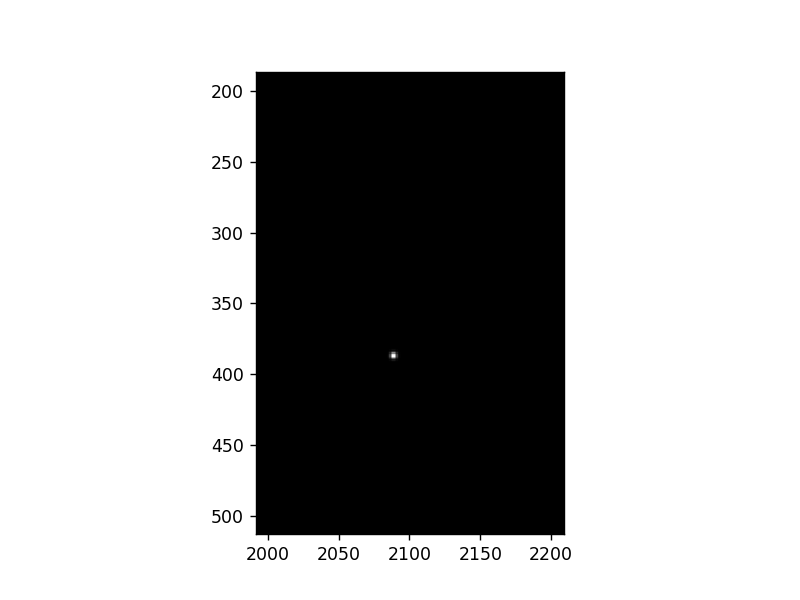

In [27]:
plt.imshow(heatmaps[:,:,0], cmap="gray")